<h1>Assignment 2 Group 10 </h1>

In [1]:
import tarfile
import pandas as pd
import os

In [2]:
def count_png_files_in_folder(folder_path):
    png_count = 0
    
    for root, dirs, files in os.walk(folder_path):
        png_count += sum(1 for file in files if file.endswith('.png'))
    return png_count

count_png_files_in_folder("/Users/renkasik/Desktop/Intro To Focus Areas/data/BreaKHis_v1")


7909

Import data to df with Benign/Malignant IDs and choosing magnification

In [3]:
def extract_image_labels(folder_path):
    file_paths = []
    labels = []

    file_paths = []
    labels = []

    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith('.png'):
                file_path = os.path.join(root, file_name)
                # Extract parts of the filename
                parts = file_name.split('-')

                label = parts[0].split('_')[1]  # 'M' or 'B' indicating malignancy
                magnification = parts[3]  # Magnification levels
                    
                # Filter for images with 100x magnification
                if magnification == '100':
                    labels.append(label)
                    file_paths.append(file_path)

    # Create a DataFrame with the extracted data
    df = pd.DataFrame({
        'FilePath': file_paths,
        'Label': labels
    })
    
    return df


In [4]:
image_labels_df = extract_image_labels("/Users/renkasik/Desktop/Intro To Focus Areas/data/BreaKHis_v1")

In [5]:
image_labels_df.head(5)

,FilePath,Label
0,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M
1,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M
2,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M
3,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M
4,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M


<h3> Split data into train. test and validation sets </h3>

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
labels = image_labels_df['Label']

X_train, X_temp = train_test_split(image_labels_df, test_size=0.3, stratify=labels, random_state = 42)

label_test_val = X_temp['Label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (1456, 2)
The shape of test data (312, 2)
The shape of validation data (313, 2)


In [8]:
# Convert Labels to Numeric
label_mapping = {'M': 1, 'B': 0}
X_train['Label'] = X_train['Label'].map(label_mapping)
X_val['Label'] = X_val['Label'].map(label_mapping)
X_test['Label'] = X_test['Label'].map(label_mapping)

<h3> Distribution of train, test and validation Datasets </h3>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

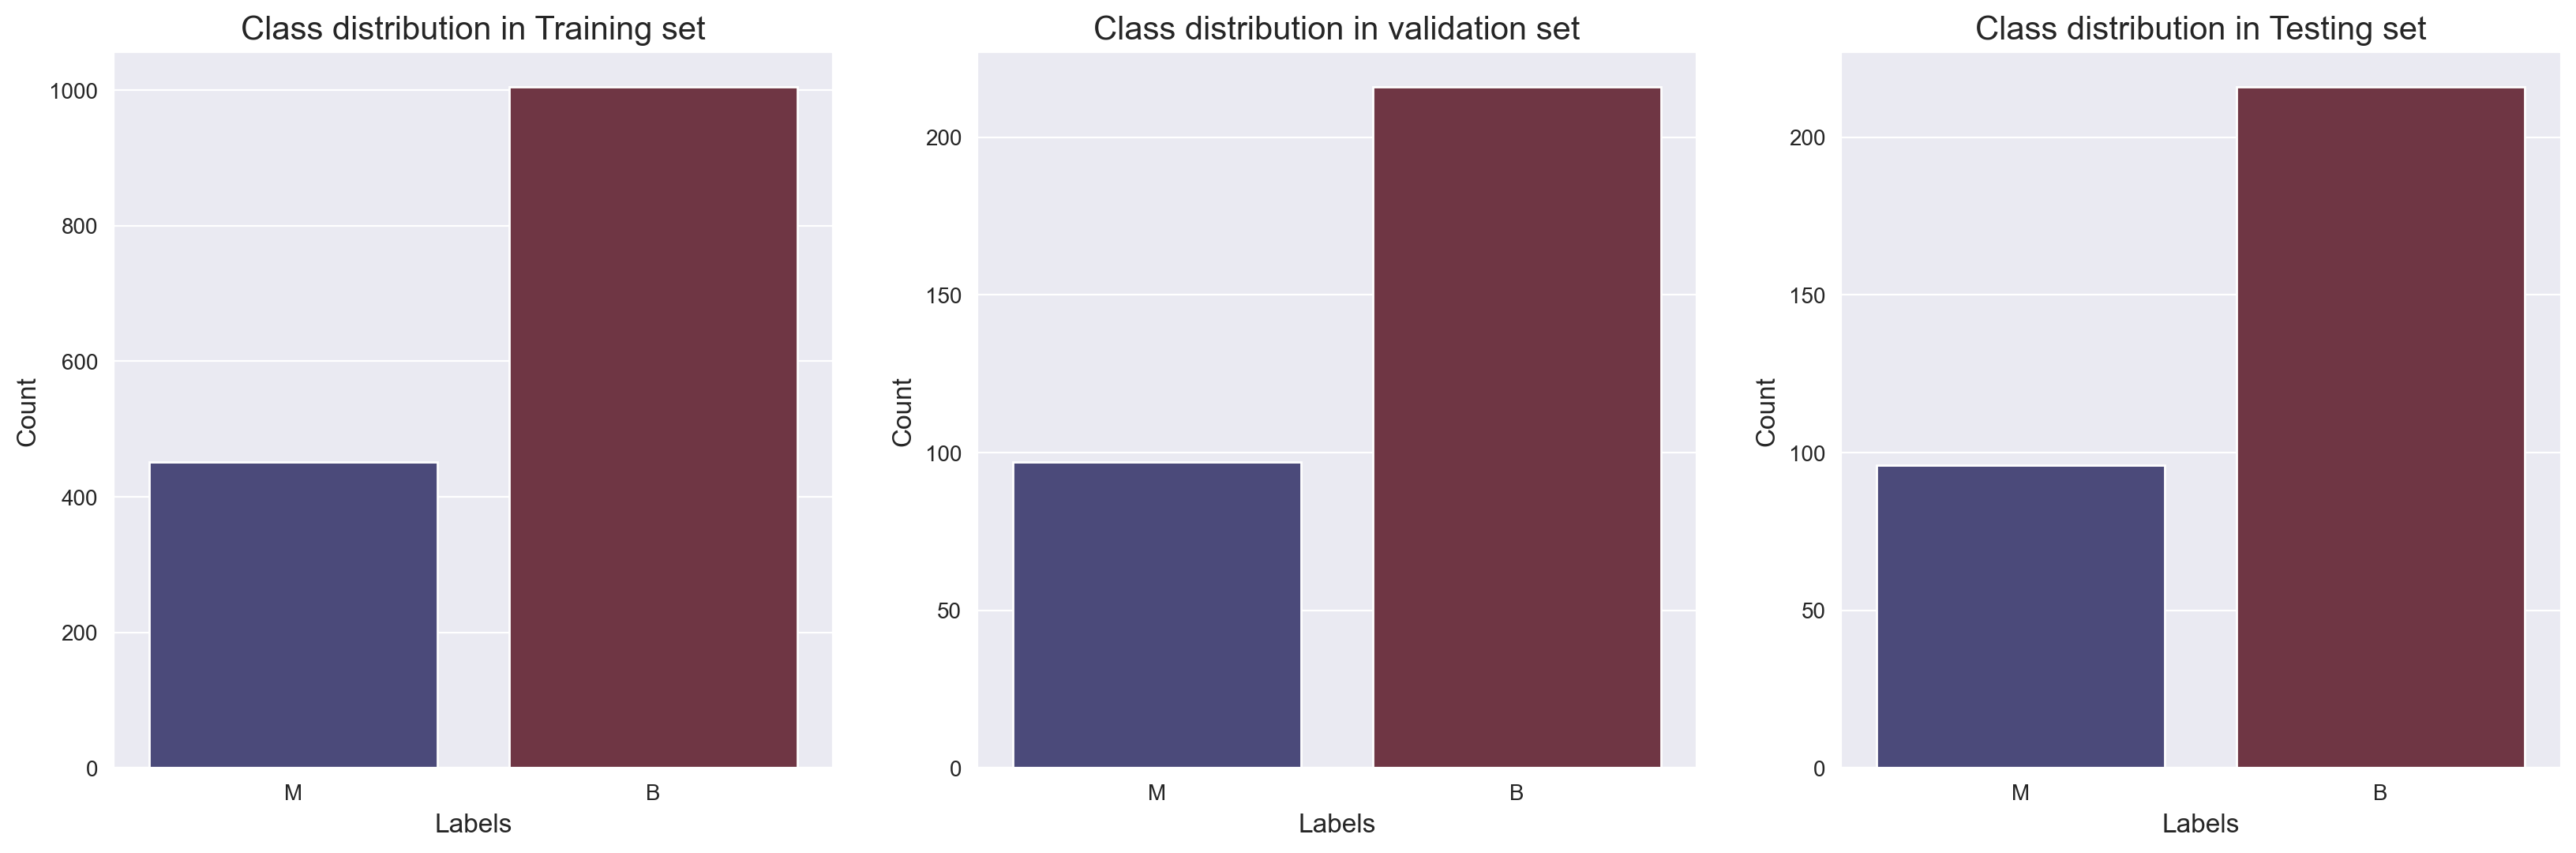

In [10]:
labels = ['M','B']

#count unique label appearances
label1,count1 = np.unique(X_train.Label,return_counts=True)
label2,count2 = np.unique(X_val.Label,return_counts=True)
label3,count3 = np.unique(X_test.Label,return_counts=True)

# DataFrames with 1 column for count of labels, label names in index
uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])

plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index, y='Count1', hue=uni1.index, palette='icefire', legend=False).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index, y='Count2', hue=uni1.index, palette='icefire', legend=False).set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index, y='Count3', hue=uni1.index, palette='icefire', legend=False).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

<h2> Deep Learning based Classifiers </h2>

In [11]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.metrics import Precision, Recall

<h3> CNN </h3>

In [12]:
# Load and preprocess data
IMG_SIZE = (32, 32)  # Adjust

def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0 # Normalize pixel values to [0, 1]
    return image

In [13]:
base_dir = "/Users/renkasik/Desktop/Intro To Focus Areas/data/BreaKHis_v1"

In [15]:
# Convert DataFrame columns to lists
train_filepaths = X_train['FilePath'].tolist()
train_labels = X_train['Label'].tolist()

val_filepaths = X_val['FilePath'].tolist()
val_labels = X_val['Label'].tolist()

test_filepaths = X_test['FilePath'].tolist()
test_labels = X_test['Label'].tolist()

# load images and labels as TensorFlow Datasets
def create_dataset(filepaths, labels):    
    # Create TensorFlow datasets from paths and labels
    filepaths_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    images_ds = filepaths_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    
    # Zip the datasets together
    return tf.data.Dataset.zip((images_ds, labels_ds))

In [16]:
i = 0
for filepath in train_filepaths:
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")

In [17]:
BATCH_SIZE = 32  # Set the batch size according to memory capacity

# Shuffle, batch, and prefetch the datasets
train_ds = create_dataset(train_filepaths, train_labels).shuffle(buffer_size=len(train_filepaths)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = create_dataset(val_filepaths, val_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = create_dataset(test_filepaths, test_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

2024-11-02 18:53:34.385959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # Adjust input_shape to image dimensions, (3,3) is filter size, 3 is RGB color channels
    layers.MaxPooling2D((2, 2)), # reduces each dimension (height and width) by half, summarizing the main features
    layers.Conv2D(64, (3, 3), activation='relu'), # 64 filters
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), # number of neurons in the layer
    layers.Dense(1, activation='sigmoid')
])

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [20]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10
46/46 [==============================] - 4s 27ms/step - loss: 0.5749 - accuracy: 0.7088 - precision: 0.7071 - recall: 0.9871 - val_loss: 0.5060 - val_accuracy: 0.7572 - val_precision: 0.8763 - val_recall: 0.7546
Epoch 2/10
46/46 [==============================] - 3s 20ms/step - loss: 0.5408 - accuracy: 0.7280 - precision: 0.7673 - recall: 0.8697 - val_loss: 0.4643 - val_accuracy: 0.7955 - val_precision: 0.8167 - val_recall: 0.9074
Epoch 3/10
46/46 [==============================] - 3s 20ms/step - loss: 0.4853 - accuracy: 0.7802 - precision: 0.7945 - recall: 0.9194 - val_loss: 0.4428 - val_accuracy: 0.8051 - val_precision: 0.8016 - val_recall: 0.9537
Epoch 4/10
46/46 [==============================] - 3s 20ms/step - loss: 0.4752 - accuracy: 0.7891 - precision: 0.8040 - recall: 0.9184 - val_loss: 0.4559 - val_accuracy: 0.8083 - val_precision: 0.8750 - val_recall: 0.8426
Epoch 5/10
46/46 [==============================] - 3s 20ms/step - loss: 0.4688 - accuracy: 0.8084 - precisi

In [21]:
results = model.evaluate(test_ds)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results)):
    print(metrics[i] + ': ' + str(results[i]))

10/10 [==============================] - 0s 47ms/step - loss: 0.4122 - accuracy: 0.8558 - precision: 0.8638 - recall: 0.9398
Loss: 0.41221940517425537
Accuracy: 0.8557692170143127
Precision: 0.8638297915458679
Recall(Sensitivity): 0.9398148059844971


<h3>Fully connected NN with one hidden layer </h3>

In [23]:
model_2 = models.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),  # fully connected -> flatten from 2D to 1D
    layers.Dense(64, activation='relu'),  # hidden layer -> learning features from the input data
    layers.Dense(1, activation='sigmoid') 
])

In [24]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [32]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10
46/46 [==============================] - 3s 26ms/step - loss: 0.3749 - accuracy: 0.8324 - precision: 0.8648 - recall: 0.8975 - val_loss: 0.4520 - val_accuracy: 0.8115 - val_precision: 0.7940 - val_recall: 0.9815
Epoch 2/10
46/46 [==============================] - 3s 24ms/step - loss: 0.3697 - accuracy: 0.8407 - precision: 0.8609 - recall: 0.9174 - val_loss: 0.3983 - val_accuracy: 0.8211 - val_precision: 0.8738 - val_recall: 0.8657
Epoch 3/10
46/46 [==============================] - 3s 21ms/step - loss: 0.3691 - accuracy: 0.8338 - precision: 0.8596 - recall: 0.9075 - val_loss: 0.4069 - val_accuracy: 0.8243 - val_precision: 0.8779 - val_recall: 0.8657
Epoch 4/10
46/46 [==============================] - 3s 20ms/step - loss: 0.3380 - accuracy: 0.8530 - precision: 0.8836 - recall: 0.9065 - val_loss: 0.5203 - val_accuracy: 0.7923 - val_precision: 0.7745 - val_recall: 0.9861
Epoch 5/10
46/46 [==============================] - 3s 20ms/step - loss: 0.3590 - accuracy: 0.8427 - precisi

In [33]:
results_2 = model_2.evaluate(test_ds)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results_2)):
    print(metrics[i] + ': ' + str(results_2[i]))

10/10 [==============================] - 0s 44ms/step - loss: 0.6009 - accuracy: 0.6923 - precision_1: 0.6923 - recall_1: 1.0000
Loss: 0.600948691368103
Accuracy: 0.692307710647583
Precision: 0.692307710647583
Recall(Sensitivity): 1.0
